# Churn Prevention

## Project Description

The telecom operator Interconnect would like to be able to forecast their churn of clients. If it's discovered that a user is planning to leave, they will be offered promotional codes and special plan options. Interconnect's marketing team has collected some of their clientele's personal data, including information about their plans and contracts.

### Interconnect's services

Interconnect mainly provides two types of services:

1. Landline communication. The telephone can be connected to several lines simultaneously.
2. Internet. The network can be set up via a telephone line (DSL, digital subscriber line) or through a fiber optic cable.

Some other services the company provides include:

* Internet security: antivirus software (DeviceProtection) and a malicious website blocker (OnlineSecurity)
* A dedicated technical support line (TechSupport)
* Cloud file storage and data backup (OnlineBackup)
* TV streaming (StreamingTV) and a movie directory (StreamingMovies)

The clients can choose either a monthly payment or sign a 1- or 2-year contract. They can use various payment methods and receive an electronic invoice after a transaction.

### Data Description

The data consists of files obtained from different sources:

- `contract.csv` — contract information
- `personal.csv` — the client's personal data
- `internet.csv` — information about Internet services
- `phone.csv` — information about telephone services

In each file, the column `customerID` contains a unique code assigned to each client.

The contract information is valid as of February 1, 2020.

### Requirements

The goal of the project is accurately predict whether a customer will churn or not. The primary metric of this performance will be the AUC-ROC. We are following the below criteria for grading:

* AUC-ROC < 0.75 — 0 SP
* 0.75 ≤ AUC-ROC < 0.81 — 4 SP
* 0.81 ≤ AUC-ROC < 0.85 — 4.5 SP
* 0.85 ≤ AUC-ROC < 0.87 — 5 SP
* 0.87 ≤ AUC-ROC < 0.88 — 5.5 SP
* AUC-ROC ≥ 0.88 — 6 SP

### Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.tree import DecisionTreeClassifier

import lightgbm as lgb

from catboost import CatBoostClassifier

## Exploratory Data Analysis

In [2]:
contract = pd.read_csv('/datasets/final_provider/contract.csv')
internet = pd.read_csv('/datasets/final_provider/internet.csv')
personal = pd.read_csv('/datasets/final_provider/personal.csv')
phone = pd.read_csv('/datasets/final_provider/phone.csv')

In [3]:
print('contract')
display(contract.head())
print()
print('================')
print()
print('internet')
display(internet.head())
print()
print('================')
print()
print('personal')
display(personal.head())
print()
print('================')
print()
print('phone')
display(phone.head())

contract


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65




internet


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No




personal


,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No




phone


,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


In [4]:
print()
print(contract.info())
print('==================')
print()
print(internet.info())
print('==================')
print()
print(personal.info())
print('==================')
print()
print(phone.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB
None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517

In [5]:
def print_nulls_duplicates(dataframes):
    for name, df in dataframes:
        duplicate_count = df.duplicated(subset='customerID').sum()
        null_count = df.isnull().sum().sum()
        print(f"There are {duplicate_count} duplicates in the '{name}' dataframe")
        print(f"There are {null_count} null values in the '{name}' dataframe")
        print('----------------------------------------------------')

In [6]:
df_tuple = [('contract', contract), ('internet', internet), ('personal', personal), ('phone', phone)]

In [7]:
print_nulls_duplicates(df_tuple)

There are 0 duplicates in the 'contract' dataframe
There are 0 null values in the 'contract' dataframe
----------------------------------------------------
There are 0 duplicates in the 'internet' dataframe
There are 0 null values in the 'internet' dataframe
----------------------------------------------------
There are 0 duplicates in the 'personal' dataframe
There are 0 null values in the 'personal' dataframe
----------------------------------------------------
There are 0 duplicates in the 'phone' dataframe
There are 0 null values in the 'phone' dataframe
----------------------------------------------------


Great, we have 0 duplicates and 0 null values in our dataset. 

Next up is standardizing the column names of each dataframe to lowercase with underscores. This will make things consistent later.

In [8]:
contract = contract.rename(columns={
    'customerID': 'customer_id',
    'BeginDate': 'begin_date',
    'EndDate': 'end_date',
    'Type': 'type',
    'PaperlessBilling': 'paperless_billing',
    'PaymentMethod': 'payment_method',
    'MonthlyCharges': 'monthly_charges',
    'TotalCharges': 'total_charges'
})

contract.head()

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


In [9]:
internet = internet.rename(columns={
    'customerID': 'customer_id',
    'InternetService': 'internet_service',
    'OnlineSecurity': 'online_security',
    'OnlineBackup': 'online_backup',
    'DeviceProtection': 'device_protection',
    'TechSupport': 'tech_support',
    'StreamingTV': 'streaming_tv',
    'StreamingMovies': 'streaming_movies'
})

internet.head()

,customer_id,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


In [10]:
personal = personal.rename(columns={
    'customerID': 'customer_id',
    'SeniorCitizen': 'senior_citizen',
    'Partner': 'partner',
    'Dependents': 'dependents'
})

personal.head()

,customer_id,gender,senior_citizen,partner,dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


In [11]:
phone = phone.rename(columns={
    'customerID': 'customer_id',
    'MultipleLines': 'multiple_lines'
})

phone.head()

,customer_id,multiple_lines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


In [12]:
print(contract[contract['total_charges'] == ' '])

     customer_id  begin_date end_date      type paperless_billing  \
488   4472-LVYGI  2020-02-01       No  Two year               Yes   
753   3115-CZMZD  2020-02-01       No  Two year                No   
936   5709-LVOEQ  2020-02-01       No  Two year                No   
1082  4367-NUYAO  2020-02-01       No  Two year                No   
1340  1371-DWPAZ  2020-02-01       No  Two year                No   
3331  7644-OMVMY  2020-02-01       No  Two year                No   
3826  3213-VVOLG  2020-02-01       No  Two year                No   
4380  2520-SGTTA  2020-02-01       No  Two year                No   
5218  2923-ARZLG  2020-02-01       No  One year               Yes   
6670  4075-WKNIU  2020-02-01       No  Two year                No   
6754  2775-SEFEE  2020-02-01       No  Two year               Yes   

                 payment_method  monthly_charges total_charges  
488   Bank transfer (automatic)            52.55                
753                Mailed check          

In [13]:
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customer_id        7043 non-null   object 
 1   begin_date         7043 non-null   object 
 2   end_date           7043 non-null   object 
 3   type               7043 non-null   object 
 4   paperless_billing  7043 non-null   object 
 5   payment_method     7043 non-null   object 
 6   monthly_charges    7043 non-null   float64
 7   total_charges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


Next, I will be creating a 'churned' column, which will serve as our target for classification. It is defined as:

* `1` if the customer has churned, indicated by a valid date in the end date column in `contracts`
* `0` if the customer has not churned, indicated by a "No" value in the end date column in `contracts`

In [14]:
contract['churned'] = contract['end_date'].apply(lambda x: 0 if x == 'No' else 1)

contract.head()

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,churned
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,0
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5,0
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,1
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,0
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,1


Now that we have a target established, let's check the balance of the classes

In [15]:
print(len(contract[contract['churned'] == 1]) / len(contract['churned']))

0.2653698707936959


About 27% of customers have churned, leaving the 'not churned' class at about 73%. We may have to do some work to balance the classes for classification later. 

Now I will want to change some data types around to be appropriate for what they are.

In [16]:
contract['end_date'] = contract['end_date'].replace('No', np.nan)

`total_charges` has some blank values in there, not nulls, just a string with an empty space. Need to take care of that in order to convert to float64

In [17]:
contract['total_charges'] = contract['total_charges'].replace(' ', 0)

In [18]:
contract['begin_date'] = pd.to_datetime(contract['begin_date'])
contract['end_date'] = pd.to_datetime(contract['end_date'])

contract['total_charges'] = contract['total_charges'].astype('float64')

In [19]:
avg_total_charges_by_status = contract.groupby('churned')['total_charges'].mean()

print(avg_total_charges_by_status)

churned
0    2549.911442
1    1531.796094
Name: total_charges, dtype: float64


In [20]:
avg_monthly_charges_by_status = contract.groupby('churned')['monthly_charges'].mean()

print(avg_monthly_charges_by_status)

churned
0    61.265124
1    74.441332
Name: monthly_charges, dtype: float64


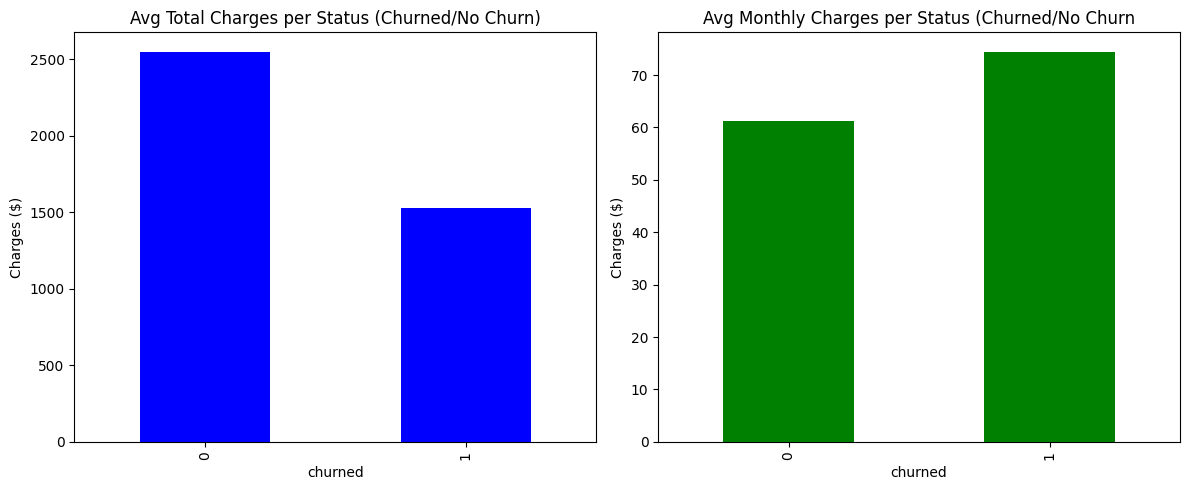

In [21]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,5))

avg_total_charges_by_status.plot(kind='bar',
                                 ax=axes[0],
                                 color='blue',
                                 title='Avg Total Charges per Status (Churned/No Churn)', 
                                 ylabel = 'Charges ($)')

avg_monthly_charges_by_status.plot(kind='bar',
                                 ax=axes[1],
                                 color='green',
                                 title= 'Avg Monthly Charges per Status (Churned/No Churn', 
                                 ylabel = 'Charges ($)')


plt.tight_layout()
plt.show()

Active customers have a higher average total charges compared to churned customers, which makes sense given that they are still current customers and still being charged for services. Interestingly, the churned customers have higher average monthly charges. Perhaps that could contribute to them churning? We will see.

Next, I will merge the datasets into one central dataframe to use. We are merging on `customer_id`. 

In [22]:
data = contract.merge(internet, on='customer_id', how='left')

In [23]:
data = data.merge(personal, on='customer_id', how='left')

In [24]:
data = data.merge(phone, on='customer_id', how='left')

In [25]:
data.head()

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,churned,internet_service,...,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,gender,senior_citizen,partner,dependents,multiple_lines
0,7590-VHVEG,2020-01-01,NaT,Month-to-month,Yes,Electronic check,29.85,29.85,0,DSL,...,Yes,No,No,No,No,Female,0,Yes,No,NaN
1,5575-GNVDE,2017-04-01,NaT,One year,No,Mailed check,56.95,1889.50,0,DSL,...,No,Yes,No,No,No,Male,0,No,No,No
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,1,DSL,...,Yes,No,No,No,No,Male,0,No,No,No
3,7795-CFOCW,2016-05-01,NaT,One year,No,Bank transfer (automatic),42.30,1840.75,0,DSL,...,No,Yes,Yes,No,No,Male,0,No,No,NaN
4,9237-HQITU,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,1,Fiber optic,...,No,No,No,No,No,Female,0,No,No,No


In [26]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           1869 non-null   datetime64[ns]
 3   type               7043 non-null   object        
 4   paperless_billing  7043 non-null   object        
 5   payment_method     7043 non-null   object        
 6   monthly_charges    7043 non-null   float64       
 7   total_charges      7043 non-null   float64       
 8   churned            7043 non-null   int64         
 9   internet_service   5517 non-null   object        
 10  online_security    5517 non-null   object        
 11  online_backup      5517 non-null   object        
 12  device_protection  5517 non-null   object        
 13  tech_support       5517 non-null   object        
 14  streamin

Perhaps having internet service is a sticking point for customers? Let's find out.

In [27]:
data['has_internet'] = data['internet_service'].apply(lambda x: 0 if pd.isna(x) else 1)

In [28]:
data['has_internet'].value_counts()

1    5517
0    1526
Name: has_internet, dtype: int64

In [29]:
internet_churned = data.groupby('churned')['has_internet'].value_counts()

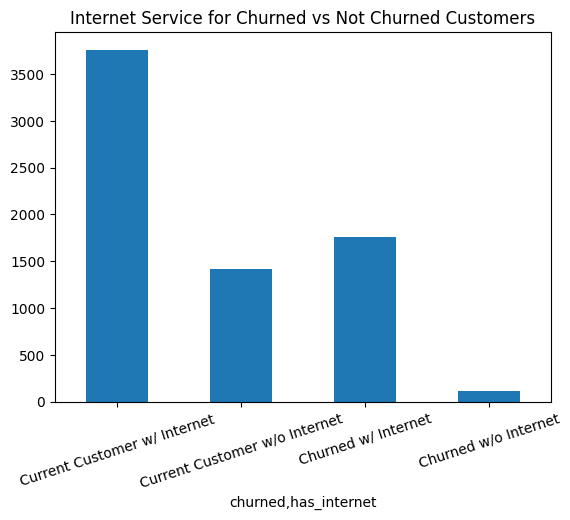

In [30]:
internet_label_list = ['Current Customer w/ Internet',
                       'Current Customer w/o Internet',
                       'Churned w/ Internet',
                       'Churned w/o Internet']

internet_plot = internet_churned.plot(kind='bar',
                      title='Internet Service for Churned vs Not Churned Customers')

internet_plot.set_xticklabels(internet_label_list)
plt.xticks(rotation=18)
plt.show()

Doesn't seem like it. Looks like most customers who churned had internet service. 

Next up, we will prepare the data for modeling. This will include:

* Removing features that will not be helpful for modeling
* One hot encoding the categorical features
* Splitting the date columns into date objects such as year, month and day, so it can be useful
* Defining a features and target dataset
* Splitting our data into train, validation and test sets

## Data Preprocessing

Now that the datasets are merged into one dataframe, we will begin by removing features that will not be used in the model. 

### Dropping Unnecessary Features

In [31]:
# looking at the columns

data.columns

Index(['customer_id', 'begin_date', 'end_date', 'type', 'paperless_billing',
       'payment_method', 'monthly_charges', 'total_charges', 'churned',
       'internet_service', 'online_security', 'online_backup',
       'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies',
       'gender', 'senior_citizen', 'partner', 'dependents', 'multiple_lines',
       'has_internet'],
      dtype='object')

The only feature that will not have an impact on predictions will likely be `customer_id`, let's remove it.

In [32]:
data = data.drop('customer_id', axis=1)

data.head()

,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,churned,internet_service,online_security,...,device_protection,tech_support,streaming_tv,streaming_movies,gender,senior_citizen,partner,dependents,multiple_lines,has_internet
0,2020-01-01,NaT,Month-to-month,Yes,Electronic check,29.85,29.85,0,DSL,No,...,No,No,No,No,Female,0,Yes,No,NaN,1
1,2017-04-01,NaT,One year,No,Mailed check,56.95,1889.50,0,DSL,Yes,...,Yes,No,No,No,Male,0,No,No,No,1
2,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,1,DSL,Yes,...,No,No,No,No,Male,0,No,No,No,1
3,2016-05-01,NaT,One year,No,Bank transfer (automatic),42.30,1840.75,0,DSL,Yes,...,Yes,Yes,No,No,Male,0,No,No,NaN,1
4,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,1,Fiber optic,No,...,No,No,No,No,Female,0,No,No,No,1


Next, we will split `begin_date` and `end_date` into date object parts: year, month and day. Then, we will remove the `begin_date` and `end_date` columns since their data has been incorporated in a different way, and the old columns are no longer useful.

### Splitting DateTimes into Parts

In [33]:
data['begin_year'] = data['begin_date'].dt.year
data['begin_month'] = data['begin_date'].dt.month
data['begin_day'] = data['begin_date'].dt.day

data['end_year'] = data['end_date'].dt.year
data['end_month'] = data['end_date'].dt.month
data['end_day'] = data['end_date'].dt.day

data = data.drop(['begin_date', 'end_date'], axis=1)

data.head()

,type,paperless_billing,payment_method,monthly_charges,total_charges,churned,internet_service,online_security,online_backup,device_protection,...,partner,dependents,multiple_lines,has_internet,begin_year,begin_month,begin_day,end_year,end_month,end_day
0,Month-to-month,Yes,Electronic check,29.85,29.85,0,DSL,No,Yes,No,...,Yes,No,NaN,1,2020,1,1,NaN,NaN,NaN
1,One year,No,Mailed check,56.95,1889.50,0,DSL,Yes,No,Yes,...,No,No,No,1,2017,4,1,NaN,NaN,NaN
2,Month-to-month,Yes,Mailed check,53.85,108.15,1,DSL,Yes,Yes,No,...,No,No,No,1,2019,10,1,2019.0,12.0,1.0
3,One year,No,Bank transfer (automatic),42.30,1840.75,0,DSL,Yes,No,Yes,...,No,No,NaN,1,2016,5,1,NaN,NaN,NaN
4,Month-to-month,Yes,Electronic check,70.70,151.65,1,Fiber optic,No,No,No,...,No,No,No,1,2019,9,1,2019.0,11.0,1.0


Now, we will one hot encode the data to accomodate for the majority of features being categorical data. This will allow us to use this data easier in various models.

**UPDATE** 

It was discovered later on that the null values in the `end_date_x` columns cannot be used for modeling. In hindsight, this data likely won't be useful anyways, because an end date requires that a customer churned, which by its essence cannot be used to forecast churn. I am dropping these columns. 

In [34]:
data = data.drop(['end_year', 'end_month', 'end_day'], axis=1)

data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 22 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   type               7043 non-null   object 
 1   paperless_billing  7043 non-null   object 
 2   payment_method     7043 non-null   object 
 3   monthly_charges    7043 non-null   float64
 4   total_charges      7043 non-null   float64
 5   churned            7043 non-null   int64  
 6   internet_service   5517 non-null   object 
 7   online_security    5517 non-null   object 
 8   online_backup      5517 non-null   object 
 9   device_protection  5517 non-null   object 
 10  tech_support       5517 non-null   object 
 11  streaming_tv       5517 non-null   object 
 12  streaming_movies   5517 non-null   object 
 13  gender             7043 non-null   object 
 14  senior_citizen     7043 non-null   int64  
 15  partner            7043 non-null   object 
 16  dependents         7043 

### One Hot Encoding

In [35]:
data_ohe = pd.get_dummies(data, drop_first=True)

data_ohe.head()

,monthly_charges,total_charges,churned,senior_citizen,has_internet,begin_year,begin_month,begin_day,type_One year,type_Two year,...,online_security_Yes,online_backup_Yes,device_protection_Yes,tech_support_Yes,streaming_tv_Yes,streaming_movies_Yes,gender_Male,partner_Yes,dependents_Yes,multiple_lines_Yes
0,29.85,29.85,0,0,1,2020,1,1,0,0,...,0,1,0,0,0,0,0,1,0,0
1,56.95,1889.50,0,0,1,2017,4,1,1,0,...,1,0,1,0,0,0,1,0,0,0
2,53.85,108.15,1,0,1,2019,10,1,0,0,...,1,1,0,0,0,0,1,0,0,0
3,42.30,1840.75,0,0,1,2016,5,1,1,0,...,1,0,1,1,0,0,1,0,0,0
4,70.70,151.65,1,0,1,2019,9,1,0,0,...,0,0,0,0,0,0,0,0,0,0


Since a lot of our features were categorical with only two categories (Yes or No), using `drop_first=True` allowed for a very minimal amount of extra added columns. That's good! 

### Defining Target and Features

In [36]:
y = data_ohe['churned']
X = data_ohe.drop('churned', axis=1)

print(y.shape)
print(X.shape)

(7043,)
(7043, 24)


Target and features defined. Next up is splitting the data.

### Train, Validation and Test Split

In order to get all 3 sets, we will first split the main dataset into an 80:20 split of train and test data. Next, we will take the train data, split it again into an 80:20 split, and we will have our train, validation and test datasets.

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [38]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(5634, 24)
(1409, 24)
(5634,)
(1409,)


In [39]:
# Splitting X_train, y_train again to get a train and validation set

X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=1)

In [40]:
print(X_train.shape)
print(X_valid.shape)
print(X_test.shape)
print(y_train.shape)
print(y_valid.shape)
print(y_test.shape)

(4507, 24)
(1127, 24)
(1409, 24)
(4507,)
(1127,)
(1409,)


We now have 3 sets of data: training, validation and test. 

We will use the train data to train the models, the validation set to evaluate the best performing, and the test data will be used as a final test for the final model. 

Moving on, we will begin our preliminary testing of various models.

## Modeling

I will be evaluating the following models, looking for the best AUC-ROC score:

* Logistic Regression (This will be our base model for comparison)
* Decision Tree
* Gradient-Boosting Models:
    * LightGBM
    * Cat Boost

### Logistic Regression

In [41]:
st = time.time()

lr = LogisticRegression(max_iter=150)

lr.fit(X_train, y_train)

y_pred_proba_lr = lr.predict_proba(X_valid)[:, 1]

auc_roc_lr = roc_auc_score(y_valid, y_pred_proba_lr)

et = time.time()
lr_time = et - st

print(f'AUC-ROC Score: {auc_roc_lr}')
print(f'Logistic Regression runtime: {lr_time}')

AUC-ROC Score: 0.8428146415366863
Logistic Regression runtime: 0.4663734436035156


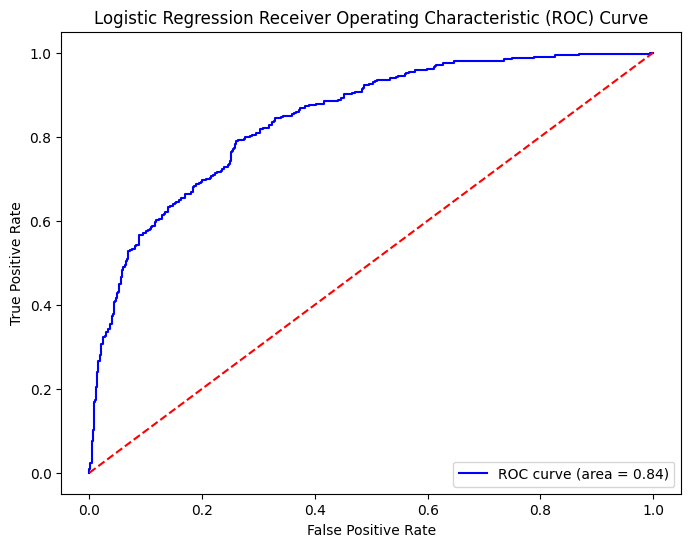

In [42]:
fpr, tpr, thresholds = roc_curve(y_valid, y_pred_proba_lr)

fig, ax = plt.subplots(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (area = {auc_roc_lr:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic Regression Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")

lr_roc_curve = fig
lr_roc_curve.show()

We now have a quick baseline model for comparison. An initial AUC-ROC score of 0.84 is pretty good to start with. Moving on, we'll now work with a decision tree. 

### Decision Tree

In [43]:
st = time.time()

param_grid = {
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 10, 20],
    'min_samples_leaf': [1, 5, 10],
    'max_features': [None, 'sqrt', 'log2'],
    'criterion': ['gini', 'entropy']
}

dt = DecisionTreeClassifier(random_state=1)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

grid_search = GridSearchCV(estimator=dt, param_grid=param_grid, cv=cv, scoring='roc_auc', n_jobs=-1)

grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
print(f'Best parameters found: {best_params}')

best_dt = grid_search.best_estimator_

y_pred_proba_dt = best_dt.predict_proba(X_valid)[:, 1]

auc_roc_dt = roc_auc_score(y_valid, y_pred_proba_dt)

et = time.time()
dt_time = et - st

print(f'AUC-ROC Score: {auc_roc_dt}')
print(f'Decision Tree runtime: {dt_time}')

Best parameters found: {'criterion': 'entropy', 'max_depth': 10, 'max_features': None, 'min_samples_leaf': 10, 'min_samples_split': 2}
AUC-ROC Score: 0.8310104324481322
Decision Tree runtime: 18.812202215194702


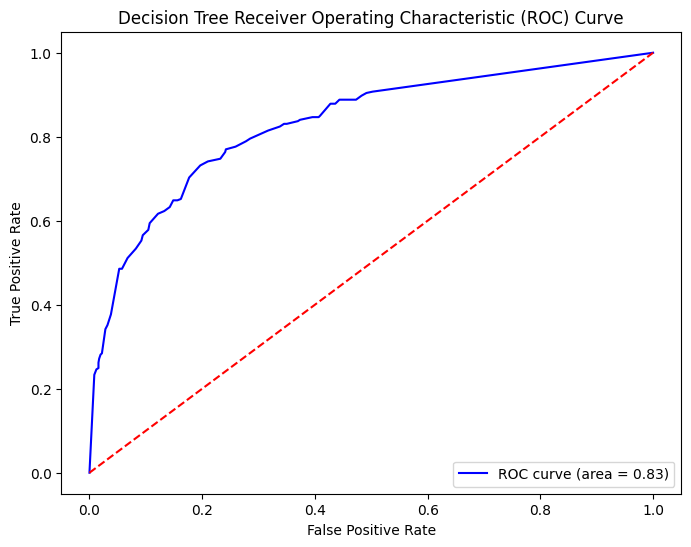

In [44]:
fpr, tpr, thresholds = roc_curve(y_valid, y_pred_proba_dt)

fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(fpr, tpr, color='blue', label=f'ROC curve (area = {auc_roc_dt:.2f})')
ax.plot([0, 1], [0, 1], color='red', linestyle='--')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Decision Tree Receiver Operating Characteristic (ROC) Curve')
ax.legend(loc="lower right")

dt_roc_curve = fig
dt_roc_curve.show()

Even with cross-validation and exhaustive tuning for hyperparameters, the Decision Tree can't reach the performance of the base model Logistic Regression. The complexity is likely too high for a single tree. 

Next up, we'll try some gradient boosting models.

### LightGBM

In [45]:
# creating LightGBM datasets
train_data = lgb.Dataset(X_train, label=y_train)
val_data = lgb.Dataset(X_valid, label=y_valid, reference=train_data)

In [46]:
st = time.time()

params = {
    'objective': 'binary',
    'metric': 'auc',
    'boosting_type': 'gbdt',
    'learning_rate': 0.1,
    'num_leaves': 31,
    'max_depth': -1,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': -1
}

callbacks = [lgb.early_stopping(10, verbose=True), lgb.log_evaluation(period=-1)]

gbm = lgb.train(params, train_data, num_boost_round=250, valid_sets=[train_data, val_data], callbacks=callbacks)

y_pred_proba_gbm = gbm.predict(X_valid, num_iteration=gbm.best_iteration)

auc_roc_gbm = roc_auc_score(y_valid, y_pred_proba_gbm)

et = time.time()
gbm_time = et - st

print(f'AUC-ROC: {auc_roc_gbm}')
print(f'LightGBM runtime: {gbm_time}')

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[101]	training's auc: 0.991959	valid_1's auc: 0.912886
AUC-ROC: 0.9128863106498889
LightGBM runtime: 0.8349921703338623


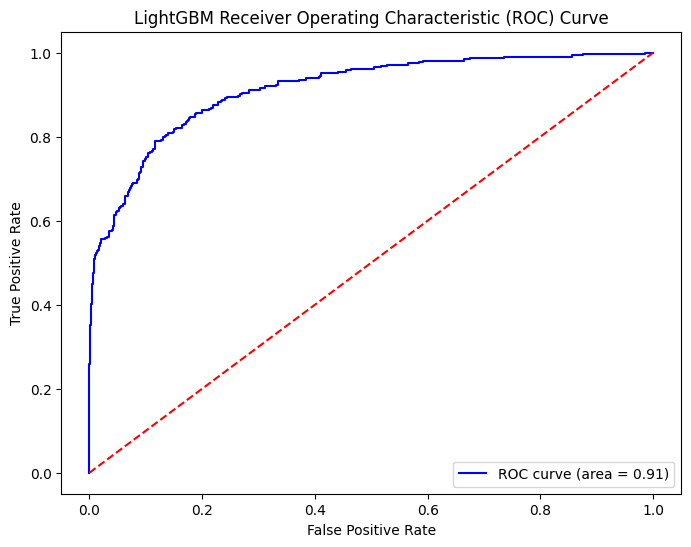

In [47]:
fpr, tpr, thresholds = roc_curve(y_valid, y_pred_proba_gbm)

fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(fpr, tpr, color='blue', label=f'ROC curve (area = {auc_roc_gbm:.2f})')
ax.plot([0, 1], [0, 1], color='red', linestyle='--')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('LightGBM Receiver Operating Characteristic (ROC) Curve')
ax.legend(loc="lower right")

gbm_roc_curve = fig
gbm_roc_curve.show()

Using gradient boosting with Light GBM seemed to work quite well. While it does take longer to run, we are looking for exceptional prediction performance. 

### CatBoost

We will have to create new features/target datasets, since CatBoost performs better with unencoded data.

In [48]:
y_cat = data['churned']
X_cat = data.drop('churned', axis=1)

print(y_cat.shape)
print(X_cat.shape)

(7043,)
(7043, 21)


In [49]:
print(X_cat.isna().sum())

type                    0
paperless_billing       0
payment_method          0
monthly_charges         0
total_charges           0
internet_service     1526
online_security      1526
online_backup        1526
device_protection    1526
tech_support         1526
streaming_tv         1526
streaming_movies     1526
gender                  0
senior_citizen          0
partner                 0
dependents              0
multiple_lines        682
has_internet            0
begin_year              0
begin_month             0
begin_day               0
dtype: int64


In [50]:
X_cat_fill = X_cat.fillna('None')

In [51]:
X_train_cat, X_test_cat, y_train_cat, y_test_cat = train_test_split(X_cat_fill, y_cat, test_size=0.2, random_state=1)

In [52]:
print(X_train_cat.shape)
print(X_test_cat.shape)
print(y_train_cat.shape)
print(y_test_cat.shape)

(5634, 21)
(1409, 21)
(5634,)
(1409,)


In [53]:
# Splitting X_train, y_train again to get a train and validation set

X_train_cat, X_valid_cat, y_train_cat, y_valid_cat = train_test_split(X_train_cat, y_train_cat, test_size=0.2, random_state=1)

In [54]:
print(X_train_cat.shape)
print(X_valid_cat.shape)
print(X_test_cat.shape)
print(y_train_cat.shape)
print(y_valid_cat.shape)
print(y_test_cat.shape)

(4507, 21)
(1127, 21)
(1409, 21)
(4507,)
(1127,)
(1409,)


In [55]:
cat_features = np.where(X_train_cat.dtypes == 'object')[0]

In [56]:
st = time.time()

catboost = CatBoostClassifier(iterations=2000,
                             learning_rate=0.1,
                             depth=6,
                             eval_metric='AUC',
                             random_seed=1)

catboost.fit(X_train_cat, y_train_cat, cat_features=cat_features, eval_set=(X_valid_cat, y_valid_cat), verbose=100, early_stopping_rounds=50)

y_pred_proba_cat = catboost.predict_proba(X_valid_cat)[:, 1]

auc_roc_cat = roc_auc_score(y_valid_cat, y_pred_proba_cat)

et = time.time()
cat_time = et - st

print(f'AUC-ROC: {auc_roc_cat}')
print(f'CatBoost runtime: {cat_time}')

0:	test: 0.7755925	best: 0.7755925 (0)	total: 74.2ms	remaining: 2m 28s
100:	test: 0.8827350	best: 0.8827350 (100)	total: 1.96s	remaining: 36.8s
200:	test: 0.8999105	best: 0.8999105 (200)	total: 4.05s	remaining: 36.3s
300:	test: 0.9063199	best: 0.9063199 (300)	total: 6.17s	remaining: 34.8s
400:	test: 0.9099583	best: 0.9099976 (396)	total: 8.32s	remaining: 33.2s
500:	test: 0.9128706	best: 0.9129138 (498)	total: 10.5s	remaining: 31.3s
600:	test: 0.9147271	best: 0.9148488 (598)	total: 12.6s	remaining: 29.4s
700:	test: 0.9153394	best: 0.9154807 (696)	total: 14.7s	remaining: 27.3s
800:	test: 0.9170781	best: 0.9170781 (800)	total: 16.9s	remaining: 25.3s
900:	test: 0.9175530	best: 0.9177885 (880)	total: 19s	remaining: 23.2s
1000:	test: 0.9187501	best: 0.9188718 (998)	total: 21.1s	remaining: 21.1s
1100:	test: 0.9203044	best: 0.9205635 (1098)	total: 23.3s	remaining: 19s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.9205634621
bestIteration = 1098

Shrink model to first 1099

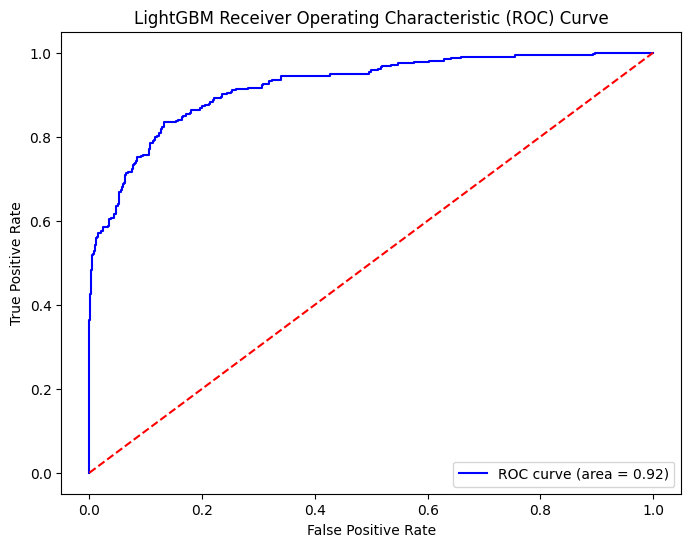

In [57]:
fpr, tpr, thresholds = roc_curve(y_valid_cat, y_pred_proba_cat)

fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(fpr, tpr, color='blue', label=f'ROC curve (area = {auc_roc_cat:.2f})')
ax.plot([0, 1], [0, 1], color='red', linestyle='--')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('LightGBM Receiver Operating Characteristic (ROC) Curve')
ax.legend(loc="lower right")

cat_roc_curve = fig
cat_roc_curve.show()

That's our best model! 0.92 AUC-ROC score. Also a very fast run time compared to the other Gradient Boosting Light GBM model. 

## Model Evaluation

Four models have been developed and evaluated using the validation set. Let's see how they fared, both in AUC-ROC scores and run times. This will help us make a decision on the bext model to use for the final evaluation. 

### Model Comparison

Below, I will plot the ROC curves for all 4 models, along with the runtime in seconds in the title.

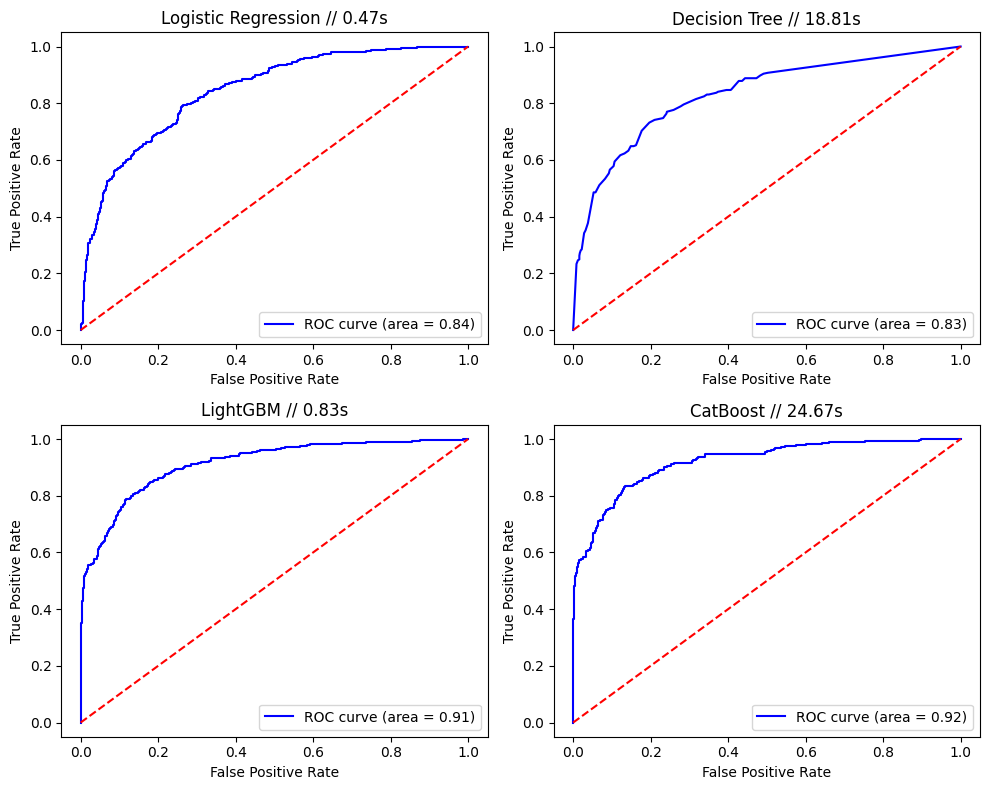

In [58]:
fig, axs = plt.subplots(2, 2, figsize=(10, 8))

def plot_data_from_fig(fig, ax):
    for original_ax in fig.axes:
        for line in original_ax.get_lines():
            ax.plot(
                line.get_xdata(), 
                line.get_ydata(), 
                label=line.get_label(), 
                color=line.get_color(), 
                linestyle=line.get_linestyle(), 
                linewidth=line.get_linewidth(), 
                marker=line.get_marker()
            )
        
        legend = original_ax.get_legend()
        if legend:
            ax.legend(loc=legend._loc)

        ax.set_title(original_ax.get_title())
        ax.set_xlabel(original_ax.get_xlabel())
        ax.set_ylabel(original_ax.get_ylabel())

plot_data_from_fig(lr_roc_curve, axs[0, 0])
axs[0, 0].set_title(f'Logistic Regression // {lr_time:.2f}s')

plot_data_from_fig(dt_roc_curve, axs[0, 1])
axs[0, 1].set_title(f'Decision Tree // {dt_time:.2f}s')

plot_data_from_fig(gbm_roc_curve, axs[1, 0])
axs[1, 0].set_title(f'LightGBM // {gbm_time:.2f}s')

plot_data_from_fig(cat_roc_curve, axs[1, 1])
axs[1, 1].set_title(f'CatBoost // {cat_time:.2f}s')

plt.tight_layout()

plt.show()

### Evaluation

Since the goal of the project is to maximize the AUC-ROC score, the winner here is the CatBoost model. The only other model that was close was the other gradient booster, Light GBM. Unfortunately, its runtime was nearly 10x longer than CatBoost's. We simply can't beat the performance, both in score and runtime. 

Our final step will be to evaluate the CatBoost model with the reserved test dataset.

## Final Model Evaluation

In [59]:
y_test_proba_cat = catboost.predict_proba(X_test_cat)[:, 1]

test_auc_roc_cat = roc_auc_score(y_test_cat, y_test_proba_cat)

print(f'Test AUC-ROC: {test_auc_roc_cat}')

Test AUC-ROC: 0.9271479952766313


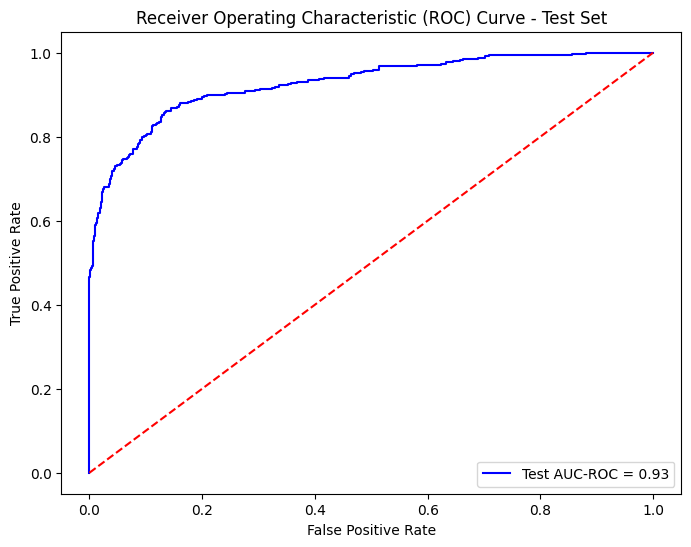

In [60]:
test_fpr, test_tpr, test_thresholds = roc_curve(y_test_cat, y_test_proba_cat)

plt.figure(figsize=(8, 6))
plt.plot(test_fpr, test_tpr, color='blue', label=f'Test AUC-ROC = {test_auc_roc_cat:.2f}')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Test Set')
plt.legend(loc="lower right")
plt.show()

A final AUC-ROC score of 0.93. This will be the model recommended to Interconnect to best forecast churn.

## Conclusion

After an exhaustive dive into 4 separate types of classifier models, we are able to proudly recommend the developed CatBoost model to Interconnect to forecast churn with their customers. With an AUC-ROC score of 0.93, this model has proven to be quite effective at distinguishing between the positive and negative class (predicting churn vs no churn). 

While it is not perfect, this could lead to a decreate in churn rate, by helping Interconnect understand which customers may need a little extra incentive to leave, before the customers decide to move on. 

Since the model takes all of these various features into account with various weights of importance, it would be very helpful to Interconnect to share the most important features for predicting churn.

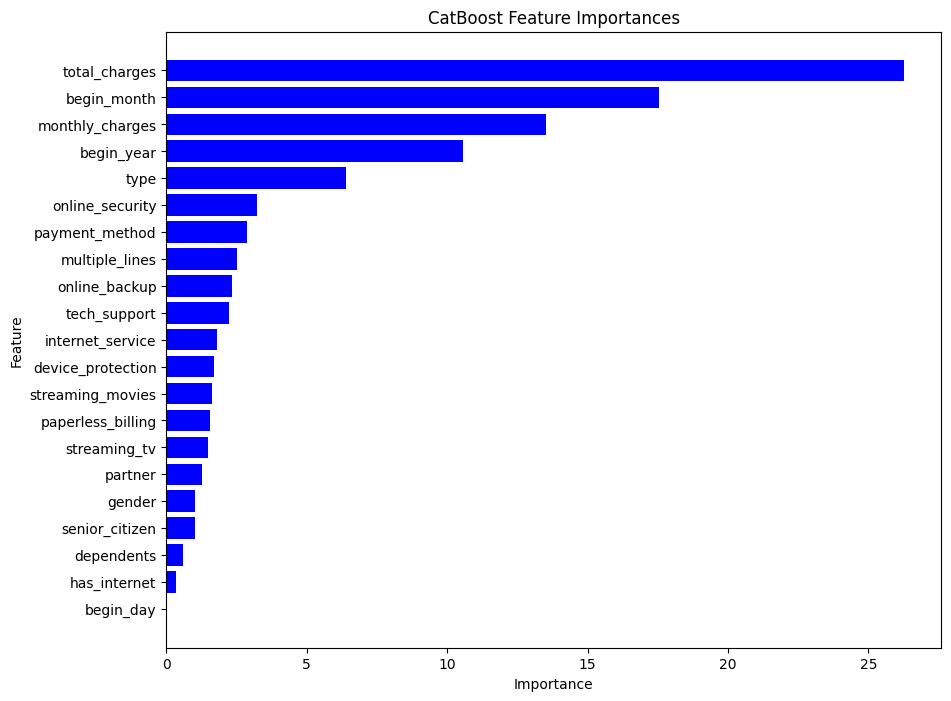

In [61]:
feature_importances = catboost.get_feature_importance()
feature_names = X_train_cat.columns

feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 8))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='blue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('CatBoost Feature Importances')
plt.gca().invert_yaxis() 
plt.show()

By far the most important feature of forecasting churn is the total charges that a customer has been charged over the lifetime of the contract. 

Moving downward, the rest of the top 5 include:

* The month the contract began (interesting)
* The monthly charges of the contract
* The year the contract began (again, interesting)
* The type of account

Without being a stakeholder at Interconnect, I cannot speak to how these features play a role or how to use this information effectively. But given their importance in the model's predictions, I would recommend the stakeholders take a deeper dive into these 5 areas, and how they play a role in a customer churning. 

I am especially interested in the date of the contract beginning. Perhaps there were incentives some months which results in not a lot of serious, long term customers, which end up churning? 

In conclusion, I believe that with this model and the top 5 important features to predictions, Interconnect will have a positive outcome on their goal of forecasting, and ultimately reducing, their churn rate.

## Final Project Report

### Project Plan vs Actual Work

Let's quickly review my proposed project work plan vs the steps that actually happened, and a brief explanation of what happened.

**Work Plan**

The end goal of this project is to develop a model that will accurately predict if a customer is going to churn, so that steps can be taken to prevent that. I will perform the following steps to reach that goal:

1. Download the data
2. Explore the data to look for any immediate problems that need to be fixed
3. Perform preprocessing for the datasets, which will be:
    * Merging the 4 datasets into one central dataset
    * Changing column names to be the standard of lowercase with underscores
    * Change datatypes to appropriate types
4. Perform EDA to examine the data in depth
5. Feature engineering
    * One hot encoding
    * Splitting datatimes into parts for better performance in modeling
6. Splitting data into train, validation and test data 
7. Creating initial instances of various models to test performance 
8. Identify the best performing model
9. Test best model with the reserved test data
10. Evaluate performance, make adjustments wherever necessary (anywhere from step 5 down to step 9), test again
11. Write a conclusion of my findings

Looking back at my proposed work plan, I did everything I set out to, and accomplished it. The only minor thing that changed was in Step 5, when I said 'Splitting datetimes into parts for better performance in modeling'. In theory, the plan implied that I was going to be splitting both `begin_date` and `end_date` into parts. In practice however, I had to change my approach and only split `begin_date`, while removing `end_date` from the features entirely. 

### Difficulties and Solutions

Some of the difficulties I came across were creating the list of features, through both feature engineering and combing through the data to determine what was necessary and what was not. 

In the end, I think I came up with a great list of features, which solved the task adequately. 

Another difficulty that I had to keep in mind was the imbalance of classes, with the 'not churned' class being roughly 3x more frequent than the churned class. One of the ways I addressed this was to use Stratifed K-folds when doing cross-validation. This helps because it keeps the class ratio the same in each of the k-folds used for cross validation. This helps to keep things consistent, without class imbalance getting in the way. 

### Key Steps to Solving The Task

While every section in this project was important to the final goal, I believe there are two things which led to the success of my model evaluating with an AUC-ROC score of 0.93:

**The curation of the features list**

This was greatly important to produce an accurate and dependable forecasting model. We had to make sure all of the features were contributing positively to the model. Things like `customer_id` or `end_date` would either be useless or could potentially lead to target leakage. 

**Gradient boosting models**

As we can see in the Model Evaluation section, the gradient boosting models were significantly more dependable than the non gradient boosting models. For this classification task, using the ensemble models which focus on converging on the most accurate parameters, were much better suited for the job. 

### One Final Conclusion

To mark the end of this notebook, a final reiteration of the best model and its results:

In [62]:
print(f'Final CatBoost model AUC-ROC score: {test_auc_roc_cat:.2f}')

Final CatBoost model AUC-ROC score: 0.93


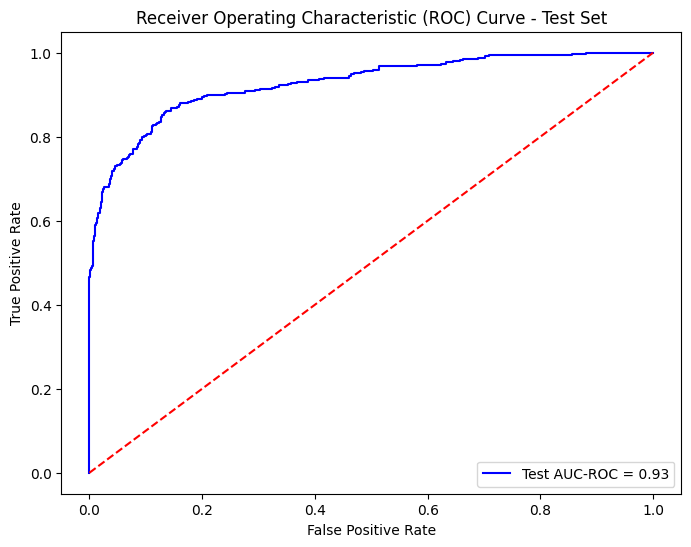

In [64]:
test_fpr, test_tpr, test_thresholds = roc_curve(y_test_cat, y_test_proba_cat)

plt.figure(figsize=(8, 6))
plt.plot(test_fpr, test_tpr, color='blue', label=f'Test AUC-ROC = {test_auc_roc_cat:.2f}')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Test Set')
plt.legend(loc="lower right")
plt.show()